<a href="https://colab.research.google.com/github/nandujkishor/15cse401-project/blob/main/stock_prediction_15cse401_project_sbin-updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 2.1MB 20.4MB/s 
     |████████████████████████████████| 9.5MB 29.3MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet
import pmdarima as pmd

# Stock Prediction using Machine Learning techniques
## Dataset - Nifty50 SBIN

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/nandujkishor/15cse401-project/main/dataset/RELIANCE.csv')
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5179,2020-10-26,RELIANCE,EQ,2113.05,2101.95,2101.95,2018.50,2034.90,2029.10,2052.69,17225340,3.535832e+15,581238.0,6324776.0,0.3672
5180,2020-10-27,RELIANCE,EQ,2029.10,2034.90,2059.85,2005.00,2034.40,2034.50,2026.38,16835011,3.411409e+15,462764.0,5199796.0,0.3089
5181,2020-10-28,RELIANCE,EQ,2034.50,2041.80,2057.70,2007.40,2008.90,2011.45,2026.02,13810054,2.797944e+15,413849.0,4822048.0,0.3492
5182,2020-10-29,RELIANCE,EQ,2011.45,1997.00,2042.00,1991.00,2029.05,2026.90,2019.57,14147681,2.857219e+15,382087.0,3346100.0,0.2365


In [4]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5.184000e+03,5.184000e+03,2.334000e+03,4.670000e+03,4670.000000
mean,987.786950,989.319367,1003.356231,973.918981,987.975174,988.138310,988.720230,5.415171e+06,5.624868e+14,1.350124e+05,2.222530e+06,0.436906
std,556.920215,558.434355,567.971926,546.551339,556.899904,557.018527,557.138677,4.804231e+06,7.660574e+14,1.181286e+05,1.834661e+06,0.145468
min,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,560.412500,563.137500,572.862500,553.512500,561.325000,561.450000,561.632500,2.813994e+06,2.168086e+14,7.104150e+04,1.177226e+06,0.324050
50%,928.400000,929.925000,940.300000,918.300000,928.200000,928.475000,928.990000,4.147698e+06,3.579790e+14,9.771400e+04,1.774500e+06,0.453300
75%,1202.387500,1202.050000,1220.825000,1180.750000,1202.462500,1203.600000,1203.470000,6.395446e+06,6.334836e+14,1.535662e+05,2.666750e+06,0.546400
max,3220.850000,3298.000000,3298.000000,3141.300000,3223.000000,3220.850000,3197.750000,6.523089e+07,1.473434e+16,1.285533e+06,3.495888e+07,0.978300


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5184 non-null   object 
 1   Symbol              5184 non-null   object 
 2   Series              5184 non-null   object 
 3   Prev Close          5184 non-null   float64
 4   Open                5184 non-null   float64
 5   High                5184 non-null   float64
 6   Low                 5184 non-null   float64
 7   Last                5184 non-null   float64
 8   Close               5184 non-null   float64
 9   VWAP                5184 non-null   float64
 10  Volume              5184 non-null   int64  
 11  Turnover            5184 non-null   float64
 12  Trades              2334 non-null   float64
 13  Deliverable Volume  4670 non-null   float64
 14  %Deliverble         4670 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 607.6

Date is used as the index for the dataframe. As part of cleaning, incomplete and unnecessary columns - series, symbol, trades, deliverable volume and deliverable - are dropped. 

In [6]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.set_index("Date", drop=False, inplace=True)
df.drop(["Series","Symbol","Trades","Deliverable Volume","%Deliverble"], axis=1, inplace=True)
df

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
Date,,,,,,,,,,
2000-01-03,2000-01-03,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14
2000-01-04,2000-01-04,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14
2000-01-05,2000-01-05,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14
2000-01-06,2000-01-06,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14
2000-01-07,2000-01-07,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14
...,...,...,...,...,...,...,...,...,...,...
2020-10-26,2020-10-26,2113.05,2101.95,2101.95,2018.50,2034.90,2029.10,2052.69,17225340,3.535832e+15
2020-10-27,2020-10-27,2029.10,2034.90,2059.85,2005.00,2034.40,2034.50,2026.38,16835011,3.411409e+15
2020-10-28,2020-10-28,2034.50,2041.80,2057.70,2007.40,2008.90,2011.45,2026.02,13810054,2.797944e+15


In [7]:
100 * df.isnull().sum() / len(df)

Date          0.0
Prev Close    0.0
Open          0.0
High          0.0
Low           0.0
Last          0.0
Close         0.0
VWAP          0.0
Volume        0.0
Turnover      0.0
dtype: float64

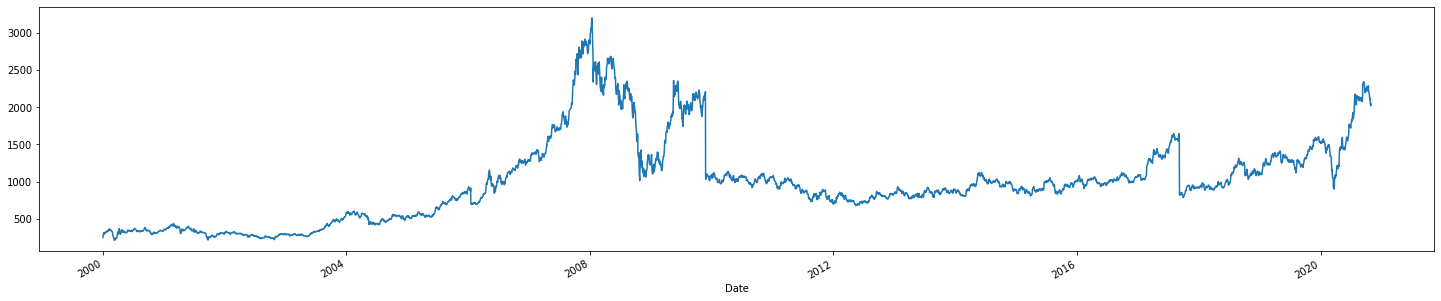

In [8]:
df.VWAP.plot(figsize=(25, 5))
plt.show()

A kernel density estimate plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. Represents the data using a continuous probability density curve in one or more dimensions.

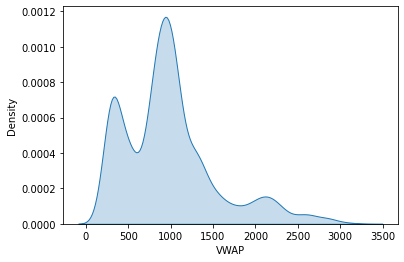

In [9]:
sns.kdeplot(df.VWAP, shade=True)
plt.show()

Adding features based on the date

In [10]:
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.isocalendar().week
df["day"] = df.Date.dt.isocalendar().day
df["day_of_week"] = df.Date.dt.dayofweek
df.drop(['Date'], axis=1, inplace=True)
df

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,month,week,day,day_of_week
Date,,,,,,,,,,,,,
2000-01-03,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,1,1,1,0
2000-01-04,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,1,1,2,1
2000-01-05,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,1,1,3,2
2000-01-06,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,1,1,4,3
2000-01-07,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,1,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,2113.05,2101.95,2101.95,2018.50,2034.90,2029.10,2052.69,17225340,3.535832e+15,10,44,1,0
2020-10-27,2029.10,2034.90,2059.85,2005.00,2034.40,2034.50,2026.38,16835011,3.411409e+15,10,44,2,1
2020-10-28,2034.50,2041.80,2057.70,2007.40,2008.90,2011.45,2026.02,13810054,2.797944e+15,10,44,3,2


In [11]:
y = df['Close']
df.drop(['VWAP', 'Close'], axis=1, inplace=True)
df

,Prev Close,Open,High,Low,Last,Volume,Turnover,month,week,day,day_of_week
Date,,,,,,,,,,,
2000-01-03,233.05,237.50,251.70,237.50,251.70,4456424,1.111319e+14,1,1,1,0
2000-01-04,251.70,258.40,271.85,251.30,271.85,9487878,2.500222e+14,1,1,2,1
2000-01-05,271.85,256.65,287.90,256.65,286.75,26833684,7.373697e+14,1,1,3,2
2000-01-06,282.50,289.00,300.70,289.00,293.50,15682286,4.633254e+14,1,1,4,3
2000-01-07,294.35,295.00,317.90,293.00,314.50,19870977,6.138388e+14,1,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,2113.05,2101.95,2101.95,2018.50,2034.90,17225340,3.535832e+15,10,44,1,0
2020-10-27,2029.10,2034.90,2059.85,2005.00,2034.40,16835011,3.411409e+15,10,44,2,1
2020-10-28,2034.50,2041.80,2057.70,2007.40,2008.90,13810054,2.797944e+15,10,44,3,2


In [12]:
indx = df.index
cols = df.columns
(indx, cols)

(DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
                '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
                '2000-01-13', '2000-01-14',
                ...
                '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
                '2020-10-23', '2020-10-26', '2020-10-27', '2020-10-28',
                '2020-10-29', '2020-10-30'],
               dtype='datetime64[ns]', name='Date', length=5184, freq=None),
 Index(['Prev Close', 'Open', 'High', 'Low', 'Last', 'Volume', 'Turnover',
        'month', 'week', 'day', 'day_of_week'],
       dtype='object'))

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)
X = pd.DataFrame(data, index=indx, columns=cols)
X

,Prev Close,Open,High,Low,Last,Volume,Turnover,month,week,day,day_of_week
Date,,,,,,,,,,,
2000-01-03,0.009892,0.010348,0.010460,0.013705,0.016028,0.067563,0.007253,0.000000,0.000000,0.000000,0.000000
2000-01-04,0.016072,0.017106,0.017005,0.018392,0.022701,0.144758,0.016682,0.000000,0.000000,0.166667,0.166667
2000-01-05,0.022749,0.016540,0.022219,0.020210,0.027635,0.410888,0.049767,0.000000,0.000000,0.333333,0.333333
2000-01-06,0.026279,0.027001,0.026376,0.031197,0.029871,0.239796,0.031163,0.000000,0.000000,0.500000,0.500000
2000-01-07,0.030206,0.028941,0.031964,0.032556,0.036825,0.304062,0.041381,0.000000,0.000000,0.666667,0.666667
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,0.632893,0.613242,0.611483,0.618634,0.606550,0.263471,0.239751,0.818182,0.826923,0.000000,0.000000
2020-10-27,0.605073,0.591560,0.597807,0.614048,0.606385,0.257482,0.231304,0.818182,0.826923,0.166667,0.166667
2020-10-28,0.606863,0.593791,0.597109,0.614863,0.597940,0.211072,0.189657,0.818182,0.826923,0.333333,0.333333


RMSE is considered as the evaluation metric

In [14]:
def get_rmse(y_test, y_pred): return np.sqrt(np.mean(np.power((np.array(y_test)-np.array(y_pred)),2)))

In [56]:
def plot(index, y_pred):
  plt.figure(figsize=(20, 5))
  plt.plot(y)
  plt.plot(index, y_pred)
  plt.show()

Train set as 80% of data with remaining 20% for test

In [ ]:
cut = int(len(X)*0.8)

# k-Nearest Neighbours algorithm

In [51]:
X_train = X[:cut]
X_test = X[cut:]
y_train = y[:cut]
y_test = y[cut:]

## Using scikit-learn library

### Without folding 

In [81]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [82]:
y_pred = knn.predict(X_test)

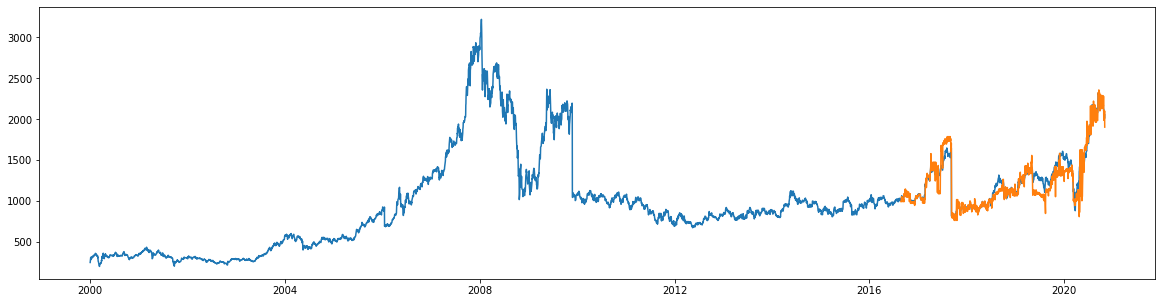

RMS value - 107.41980217010375


In [83]:
plot(y_test.index, y_pred)
rmse_knn_fl = get_rmse(y_test, y_pred)
print("RMS value -", rmse_knn_fl)

## Implementation from scratch

In [86]:
def get_val(x_train, test_r, y_test, n_neighbors):
    distances = []
    for i in range(len(x_train)):
        dist = euclidean_distances([test_r], [x_train[i]])[0][0]
        distances.append((i, dist))
    distances.sort(key=lambda tup: tup[1])
    v = 0
    for i in range(n_neighbors):
        v += y_test[distances[i][0]]
    return v/n_neighbors

### Train and test without k-Fold

In [87]:
X_train = X[:cut]
X_test = X[cut:]
y_train = y[:cut]
y_test = y[cut:]

In [88]:
y_pred = []
for i in X_test.values:
    y_pred.append(get_val(X_train.values, i, y_train, 2))

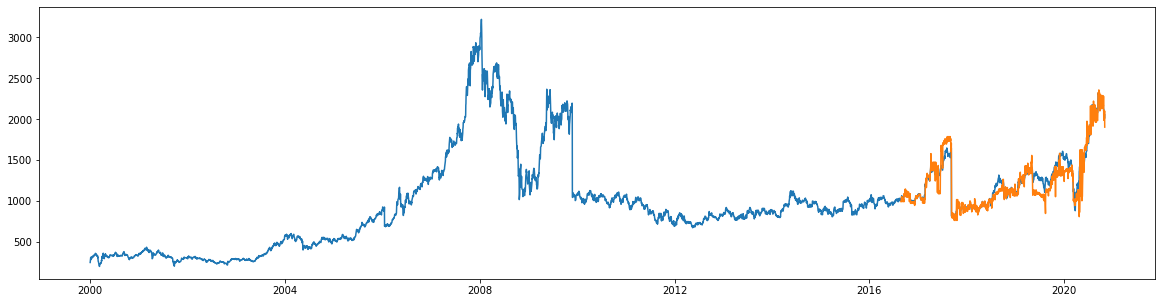

RMS value - 107.41980217010375


In [89]:
plot(y_test.index, y_pred)
rmse_knn_fl_fn = get_rmse(y_test, y_pred)
print("RMS value -", rmse_knn_fl_fn)

### Train and test with 10 folds (Folds created using TimeSeriesSplit)

In [90]:
ts = TimeSeriesSplit(n_splits=10)

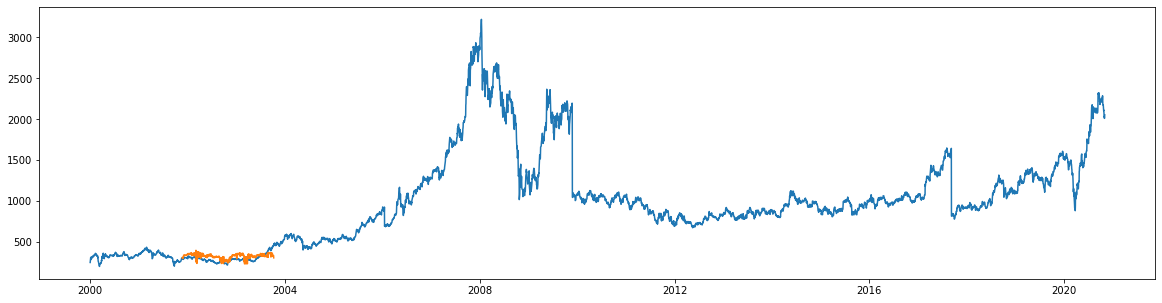

RMSE value - 50.39807539167258


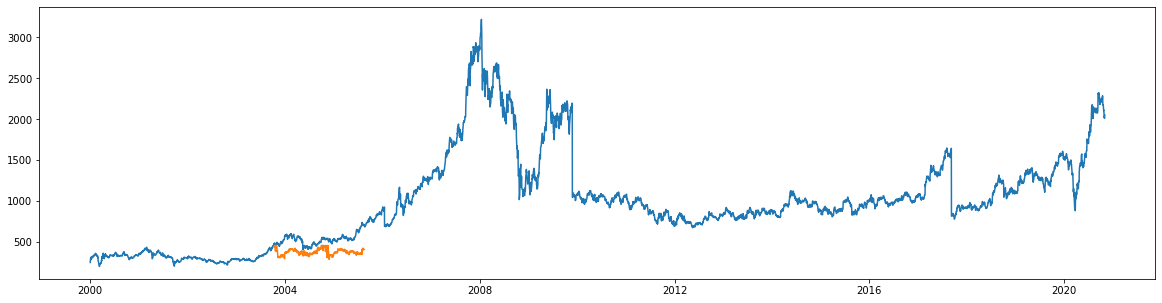

RMSE value - 165.38468016612603


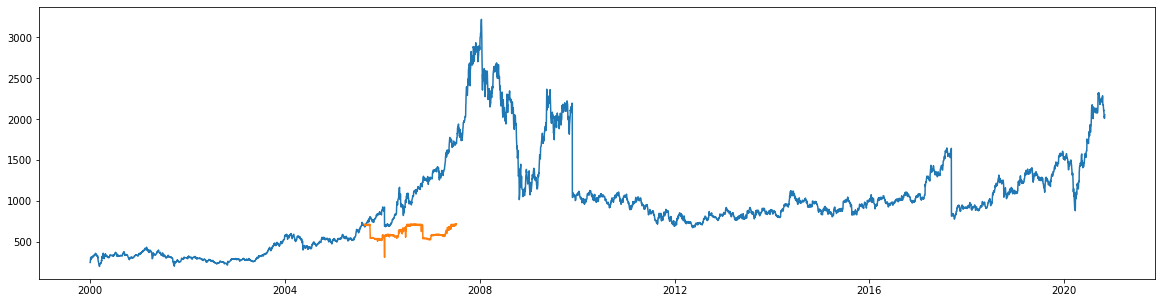

RMSE value - 563.334515286719


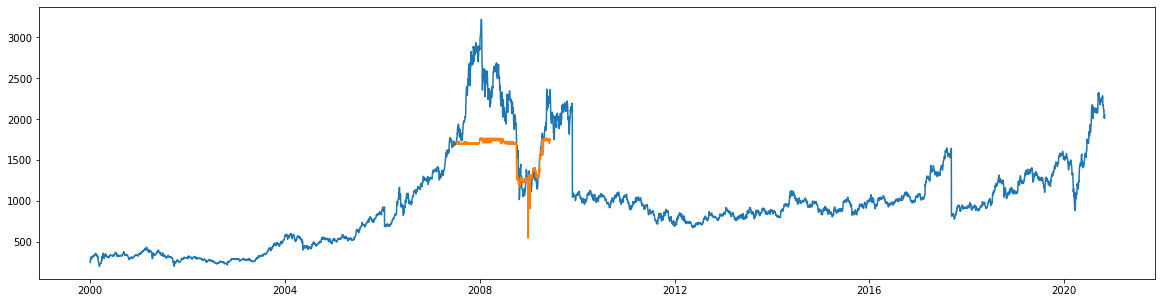

RMSE value - 595.6049325501583


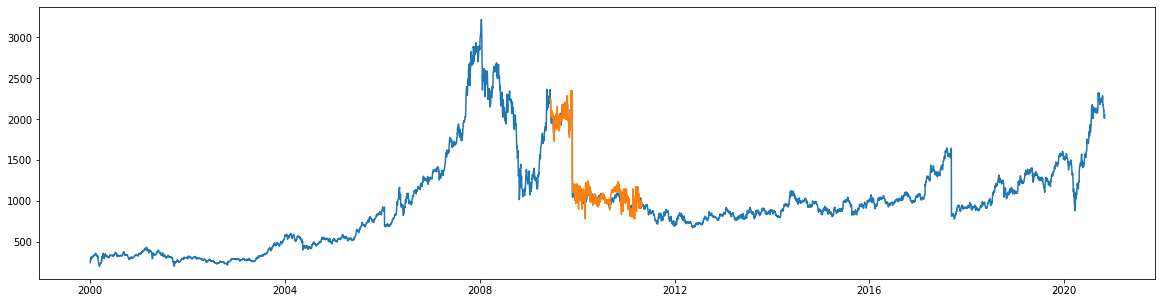

RMSE value - 73.62837927822399


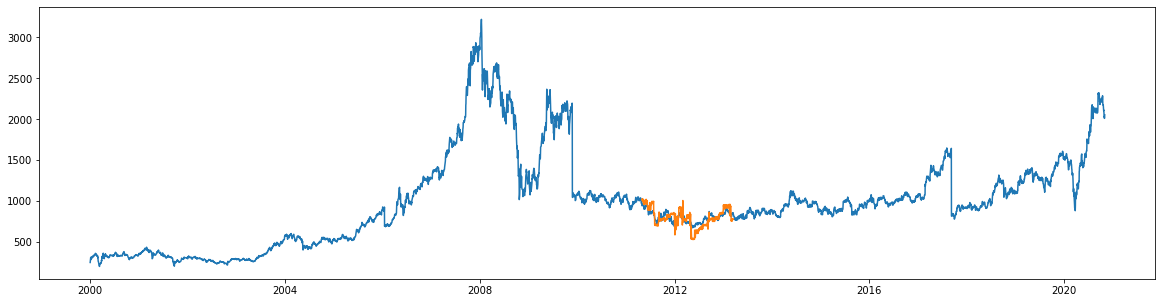

RMSE value - 73.37461495791939


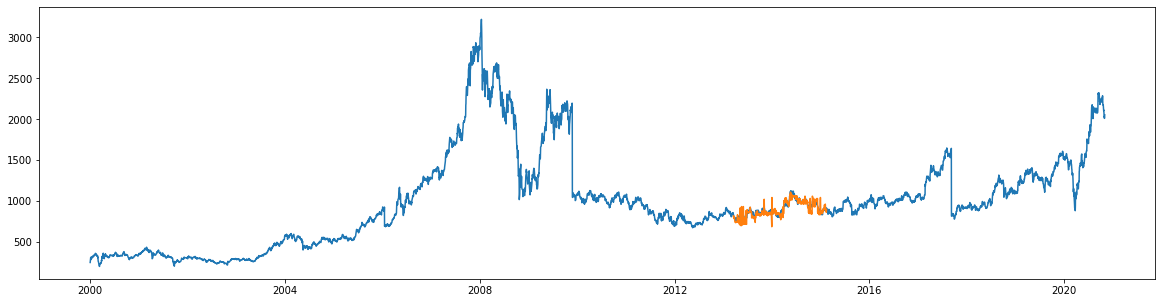

RMSE value - 43.52047793550305


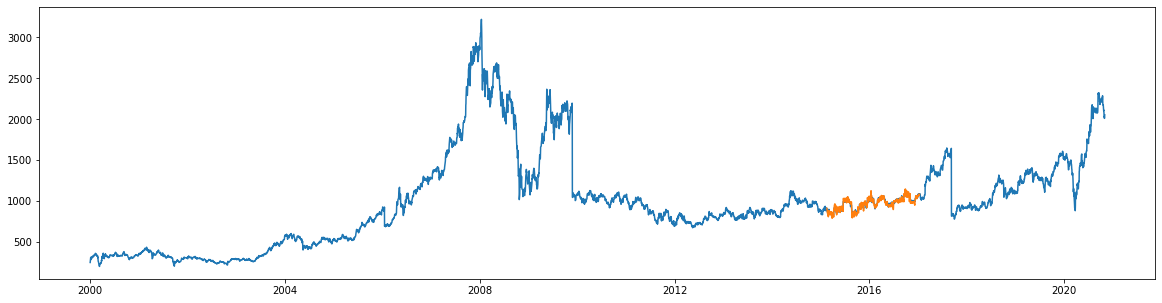

RMSE value - 23.971847181053068


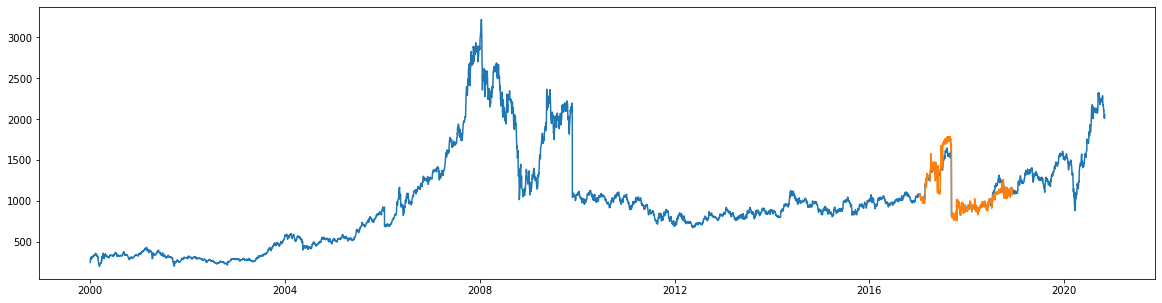

RMSE value - 87.31068482558922


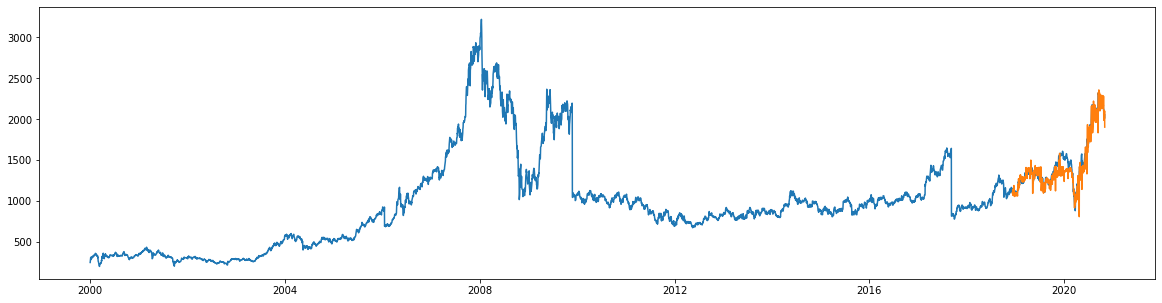

RMSE value - 102.84562090007877


In [91]:
y_preds = []
rmses = []
for train_index,test_index in ts.split(X):
    X_train,X_test = X.values[train_index],X.values[test_index]
    y_train,y_test = y.values[train_index],y.values[test_index]
    y_pred = []
    for row in X_test:
        y_pred.append(get_val(X_train, row, y_train, 2))
    plt.figure(figsize=(20, 5))
    plt.plot(indx, y.values)
    plt.plot(indx[test_index], y_pred)
    plt.show()
    rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(y_pred)),2)))
    rmses.append(rmse)
    print("RMSE value -", rmse)

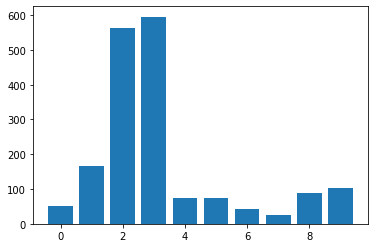

177.93738284730435


In [92]:
plt.bar(range(10), rmses)
plt.show()
rmse_knn_avg = np.mean(rmses)
print(rmse_knn_avg)

In [93]:
fn_ts = TimeSeriesSplit(n_splits=10)

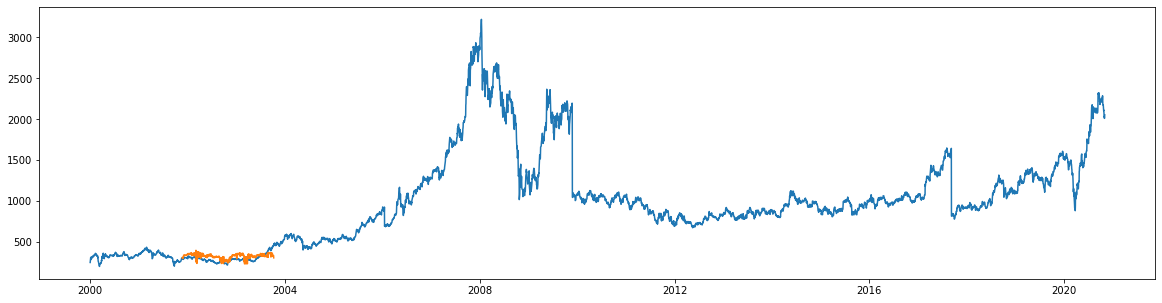

RMSE -  50.39807539167258


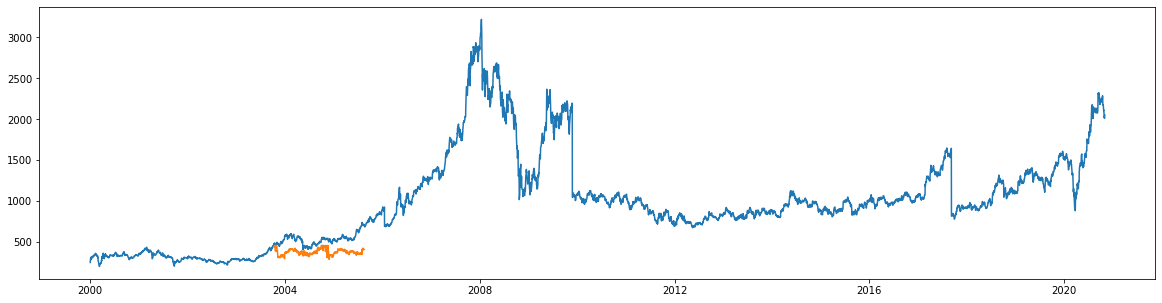

RMSE -  165.38468016612603


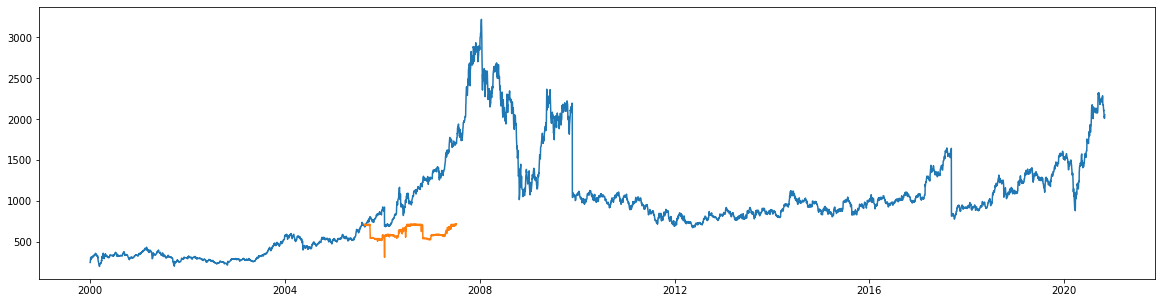

RMSE -  563.334515286719


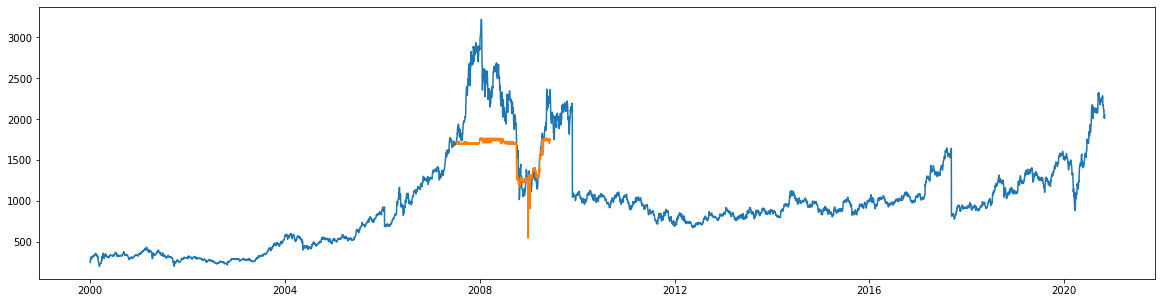

RMSE -  595.6049325501583


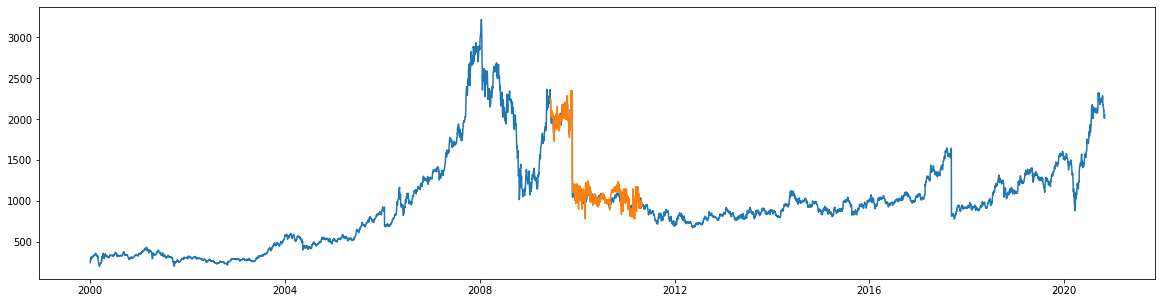

RMSE -  73.62837927822399


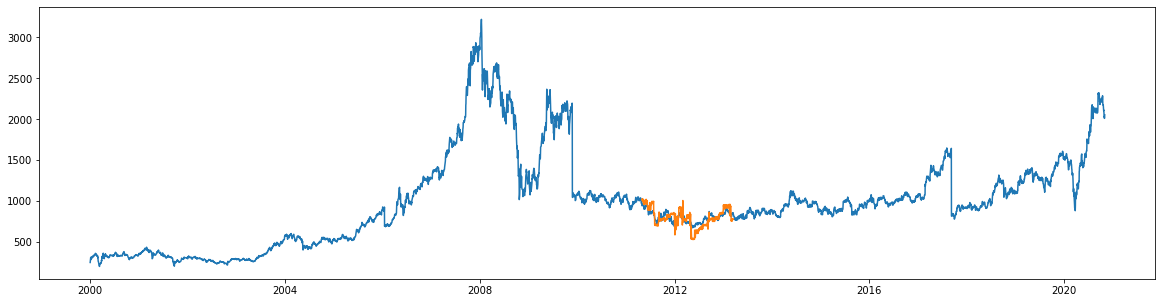

RMSE -  73.37461495791939


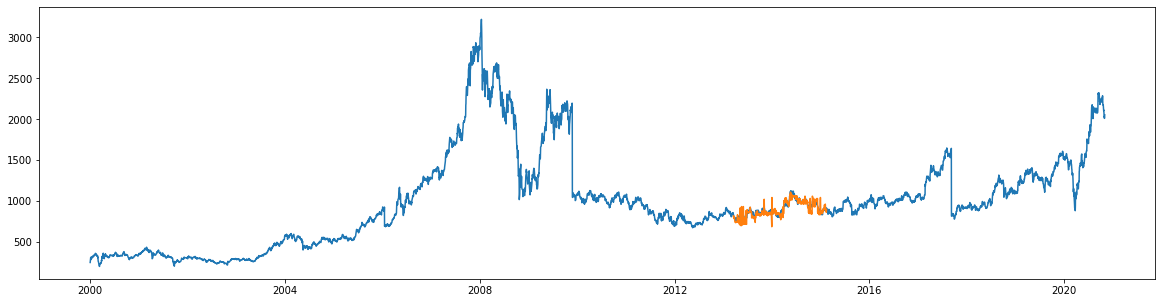

RMSE -  43.52047793550305


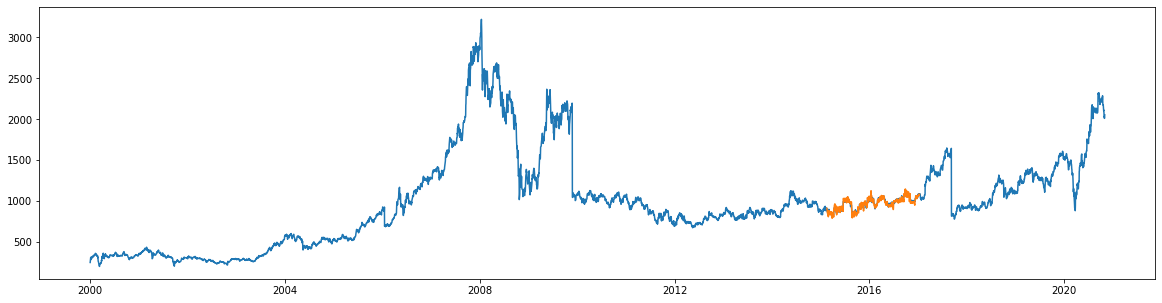

RMSE -  23.971847181053068


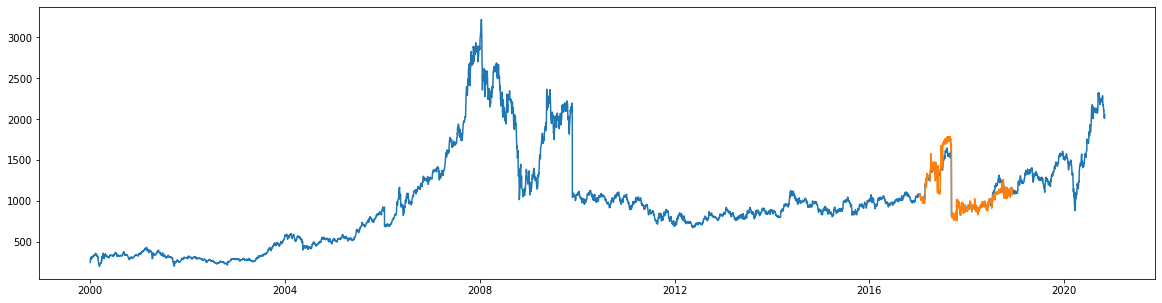

RMSE -  87.31068482558922


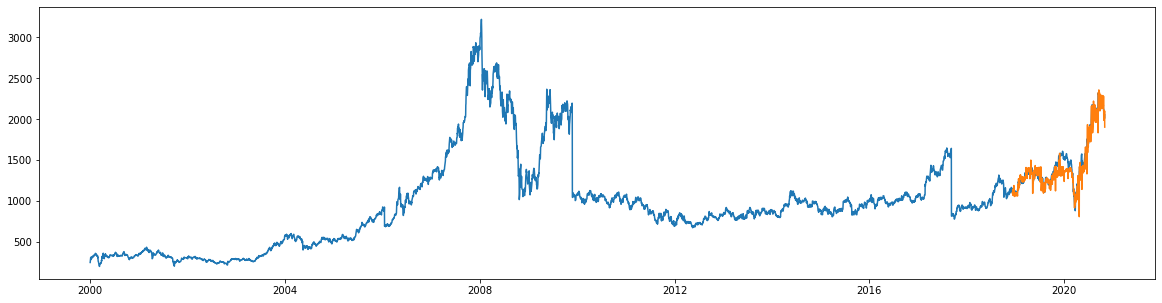

RMSE -  102.84562090007877


In [94]:
fn_y_preds = []
fn_rmses = []
knn = KNeighborsRegressor(n_neighbors=2)
for train_index,test_index in fn_ts.split(X):
    X_train,X_test = X.values[train_index],X.values[test_index]
    y_train,y_test = y.values[train_index],y.values[test_index]
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    fn_y_preds.append(y_pred)
    plt.figure(figsize=(20, 5))
    plt.plot(indx, y.values)
    plt.plot(indx[test_index], y_pred)
    plt.show()
    rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(y_pred)),2)))
    fn_rmses.append(rmse)
    print("RMSE - ", rmse)

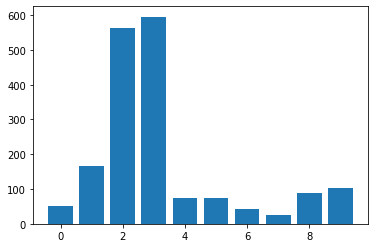

177.93738284730435


In [95]:
plt.bar(range(10), fn_rmses)
plt.show()
print(np.mean(fn_rmses))

# Linear Regression with Principal Component Analysis

## Using scikit-learn library

### Without folding

In [96]:
X_train = X[:cut]
X_test = X[cut:]
y_train = y[:cut]
y_test = y[cut:]

In [97]:
pca = PCA(n_components=2)
X_p = pca.fit_transform(df)
X_p

array([[-4.51354863e+14,  1.44284314e+06],
       [-3.12464587e+14,  5.73528325e+06],
       [ 1.74882950e+14,  2.04879877e+07],
       ...,
       [ 2.23545746e+15, -3.49964141e+06],
       [ 2.29473181e+15, -3.47740410e+06],
       [ 2.64157395e+15, -3.76945557e+06]])

In [98]:
X_p = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_p)
X_p

array([[0.00725296, 0.33917128],
       [0.01668201, 0.42230474],
       [0.04976729, 0.70802647],
       ...,
       [0.18965655, 0.24344814],
       [0.19368059, 0.24387882],
       [0.21722718, 0.23822254]])

In [99]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred_lr = model.predict(X_test)

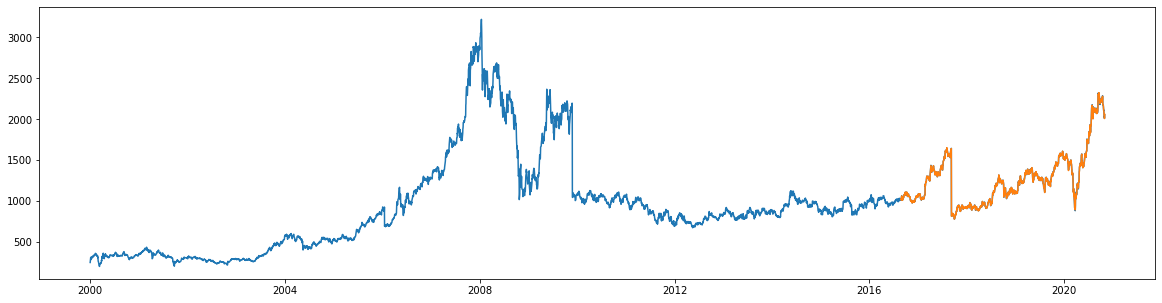

RMSE value = 2.7680340162307764


In [100]:
plt.figure(figsize=(20, 5))
plt.plot(y)
plt.plot(y_test.index, y_pred_lr)
plt.show()
rmse_lr_fl = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(y_pred_lr)),2)))
print("RMSE value =", rmse_lr_fl)

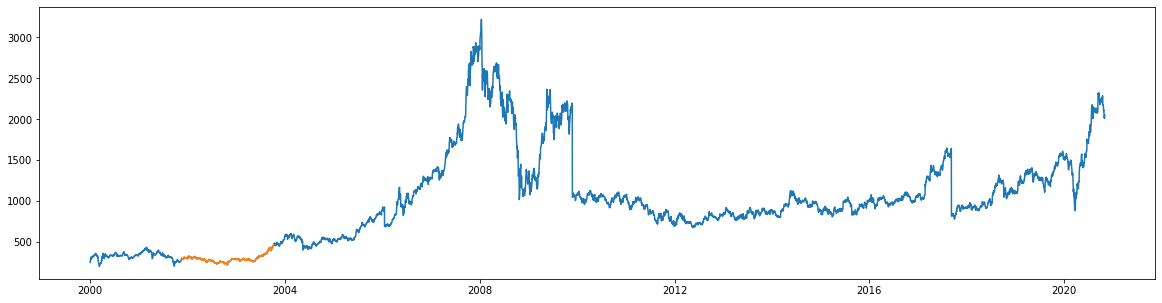

RMSE value - 0.920420251992479


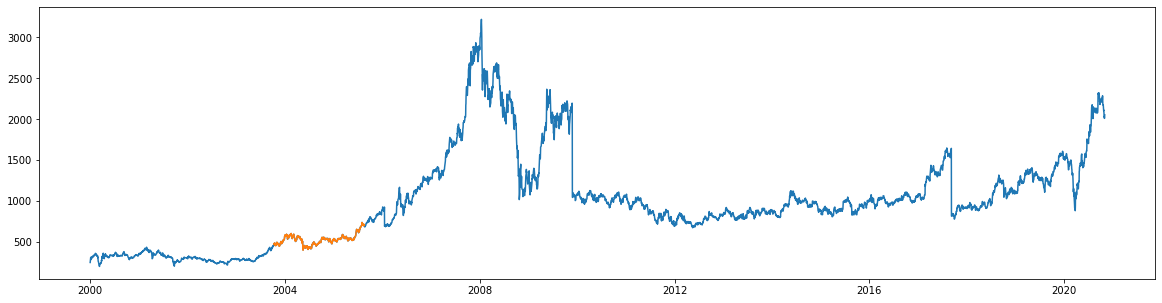

RMSE value - 1.7026842191509113


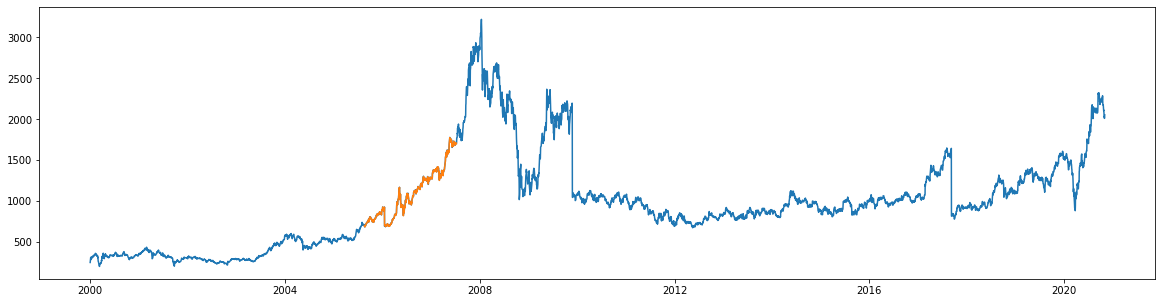

RMSE value - 2.926292316417476


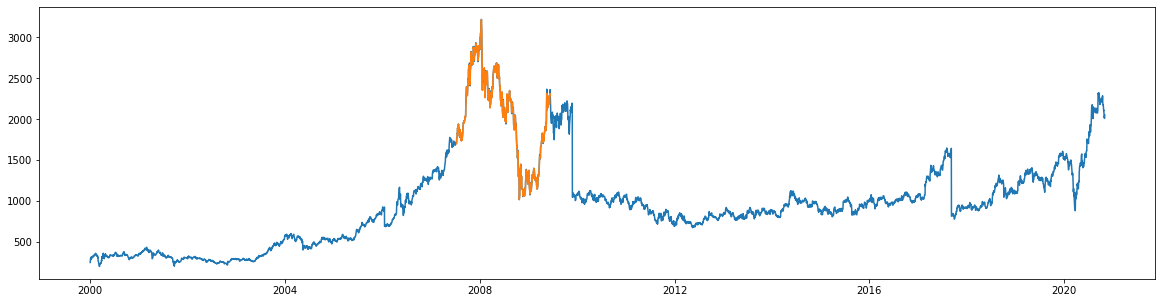

RMSE value - 8.335132697573497


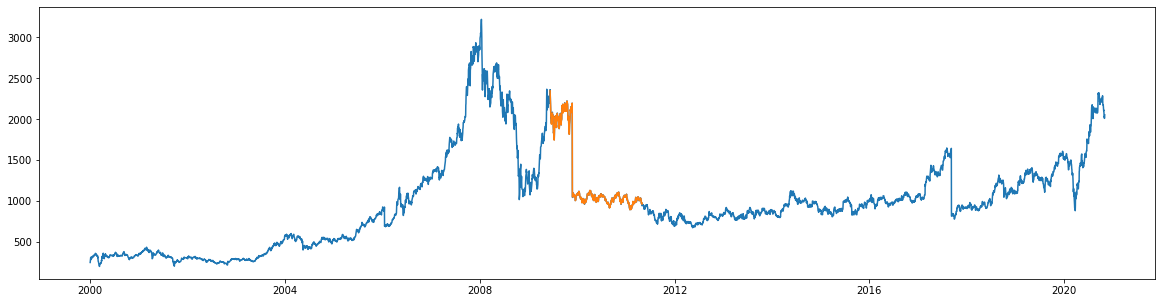

RMSE value - 3.299990797531021


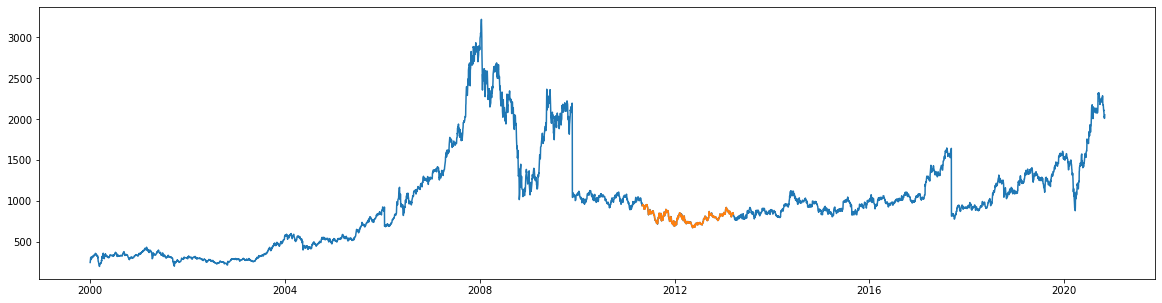

RMSE value - 1.8781789241739277


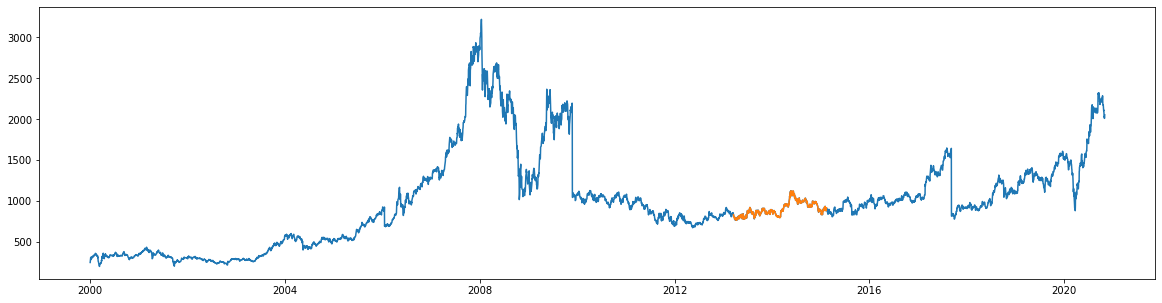

RMSE value - 1.8450897496875838


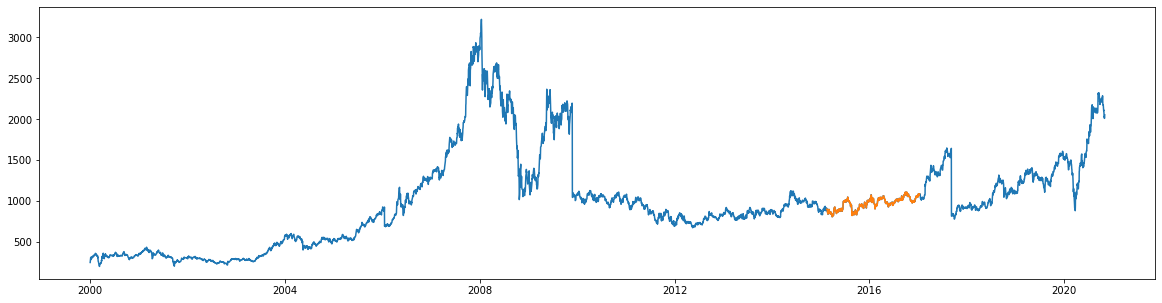

RMSE value - 1.8300237899716925


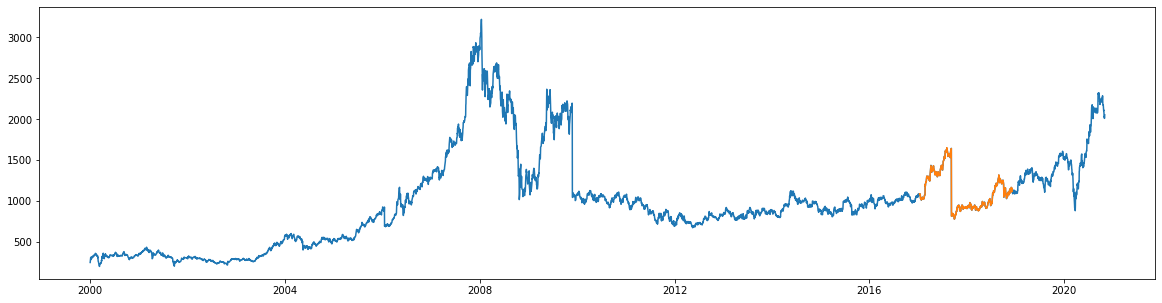

RMSE value - 2.03343156537298


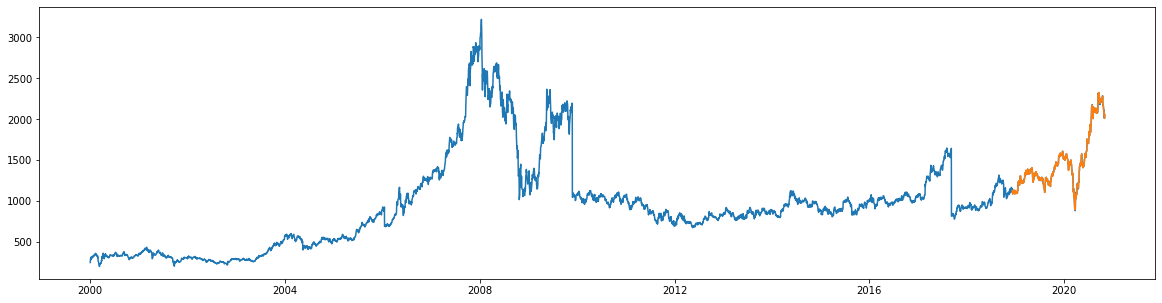

RMSE value - 3.2031369021504785


In [101]:
rmses_lr =[]
for train_index,test_index in ts.split(X):
    X_train,X_test = X.values[train_index],X.values[test_index]
    y_train,y_test = y.values[train_index],y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = get_rmse(y_pred, y_test)
    rmses_lr.append(rmse)
    plt.figure(figsize=(20, 5))
    plt.plot(y)
    plt.plot(indx[test_index], y_pred)
    plt.show()
    print("RMSE value -", rmse)

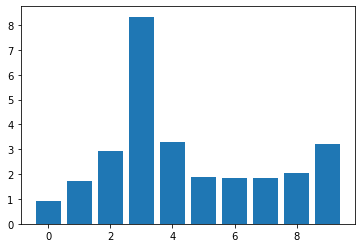

RMSE value -  2.797438121402205


In [102]:
rmse_lr_avg = np.mean(rmses_lr)
plt.bar(range(10), rmses_lr)
plt.show()
print("RMSE value - ", rmse_lr_avg)

## Implementation from scratch

In [103]:
X_train = X[:cut]
X_test = X[cut:]
y_train = y[:cut]
y_test = y[cut:]

In [108]:
class LinearRegression() : 
  def __init__(self, learning_rate, iterations):
    self.learning_rate = learning_rate
    self.iterations = iterations
  
  def fit(self, X, Y):
    self.m, self.n = X.shape
    self.W = np.zeros(self.n)
    self.b = 0
    self.X = X
    self.Y = Y 
		
    for i in range(self.iterations):
      self.update_weights()

    return self
	
  def update_weights( self ) : 
    Y_pred = self.predict(self.X)
    dW = - (2 * (self.X.T).dot(self.Y - Y_pred)) / self.m
    db = - 2 * np.sum(self.Y-Y_pred)/self.m
    self.W = self.W - self.learning_rate * dW 
    self.b = self.b - self.learning_rate * db 
    return self
		
  def predict(self, X): 
    return X.dot( self.W ) + self.b

### Without folding

In [111]:
lrm = LinearRegression(learning_rate=0.05,iterations=1000)

In [112]:
lrm.fit(X_train, y_train)

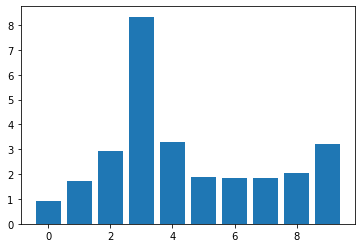

RMSE value -  2.797438121402205


In [113]:
rmse_lr_avg = np.mean(rmses_lr)
plt.bar(range(10), rmses_lr)
plt.show()
print("RMSE value - ", rmse_lr_avg)

# FbProphet for timeseries prediction

## Without folding

In [114]:
X_pr = pd.DataFrame(y.values, columns=['Close'])
X_pr['Date'] = y.index
X_train = X_pr[:cut]
X_test = X_pr[cut:]

In [115]:
model = Prophet(daily_seasonality=True)
model.fit(X_train[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"}))

In [116]:
forecast = model.predict(X_test[["Date", "Close"]].rename(columns={"Date": "ds"}))
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-08-24,944.541476,870.915148,1137.185465,944.541476,944.541476,51.440977,51.440977,51.440977,71.435797,71.435797,71.435797,-3.808586,-3.808586,-3.808586,-16.186235,-16.186235,-16.186235,0.0,0.0,0.0,995.982453
1,2016-08-25,944.676906,868.333661,1125.663472,944.676906,944.676906,51.050564,51.050564,51.050564,71.435797,71.435797,71.435797,-4.933094,-4.933094,-4.933094,-15.452139,-15.452139,-15.452139,0.0,0.0,0.0,995.727470
2,2016-08-26,944.812336,865.778761,1140.990218,944.812336,944.812336,51.035876,51.035876,51.035876,71.435797,71.435797,71.435797,-5.848192,-5.848192,-5.848192,-14.551729,-14.551729,-14.551729,0.0,0.0,0.0,995.848211
3,2016-08-29,945.218626,868.605455,1133.968599,945.218626,945.218626,51.884815,51.884815,51.884815,71.435797,71.435797,71.435797,-8.588083,-8.588083,-8.588083,-10.962900,-10.962900,-10.962900,0.0,0.0,0.0,997.103440
4,2016-08-30,945.354056,869.869147,1138.729366,945.354056,945.354056,55.497100,55.497100,55.497100,71.435797,71.435797,71.435797,-6.421728,-6.421728,-6.421728,-9.516970,-9.516970,-9.516970,0.0,0.0,0.0,1000.851156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,2020-10-26,1150.936843,-5045.950935,7106.030797,-5128.583961,6997.040598,85.919006,85.919006,85.919006,71.435797,71.435797,71.435797,-8.588083,-8.588083,-8.588083,23.071292,23.071292,23.071292,0.0,0.0,0.0,1236.855849
1033,2020-10-27,1151.072273,-5020.967454,7099.862942,-5133.470726,7004.583602,88.517890,88.517890,88.517890,71.435797,71.435797,71.435797,-6.421728,-6.421728,-6.421728,23.503820,23.503820,23.503820,0.0,0.0,0.0,1239.590163
1034,2020-10-28,1151.207703,-4955.848572,7193.756476,-5138.357491,7012.126606,91.694773,91.694773,91.694773,71.435797,71.435797,71.435797,-3.808586,-3.808586,-3.808586,24.067561,24.067561,24.067561,0.0,0.0,0.0,1242.902476
1035,2020-10-29,1151.343133,-5069.520159,7063.697426,-5143.244257,7019.669610,91.257509,91.257509,91.257509,71.435797,71.435797,71.435797,-4.933094,-4.933094,-4.933094,24.754806,24.754806,24.754806,0.0,0.0,0.0,1242.600643


In [117]:
forecast.yhat

0        995.982453
1        995.727470
2        995.848211
3        997.103440
4       1000.851156
           ...     
1032    1236.855849
1033    1239.590163
1034    1242.902476
1035    1242.600643
1036    1242.620037
Name: yhat, Length: 1037, dtype: float64

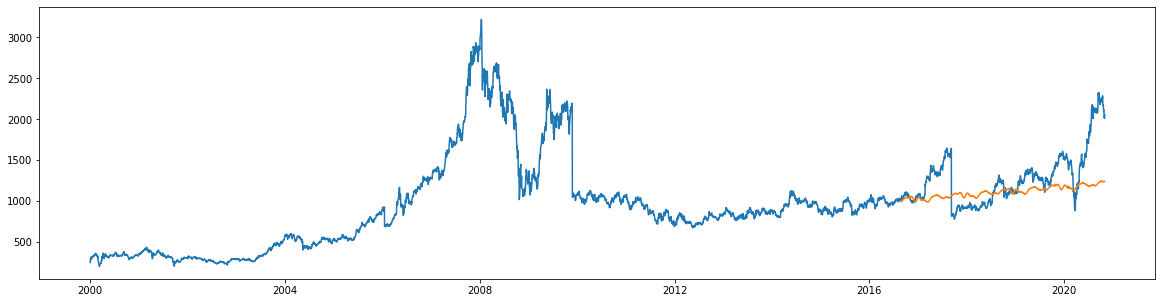

RMSE value =  337.92221500475534


In [120]:
plot(X_test["Date"], forecast.yhat)
rmse_pr_fl = get_rmse(X_test["Close"], forecast.yhat)
print("RMSE value = ", rmse_pr_fl)

## With TimeSeriesSplit

In [121]:
ts = TimeSeriesSplit(n_splits=10)

In [127]:
y_test

1020.5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<Figure size 1440x360 with 0 Axes>

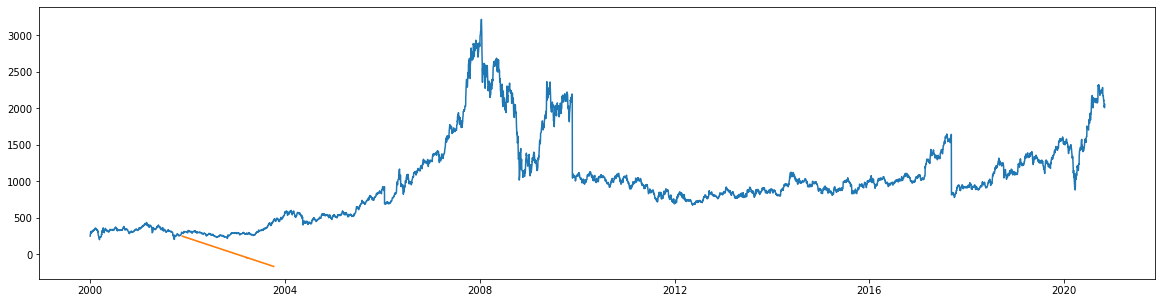

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

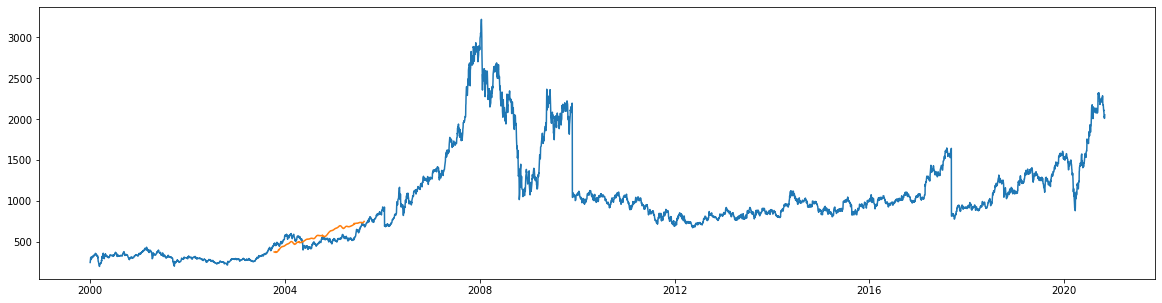

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

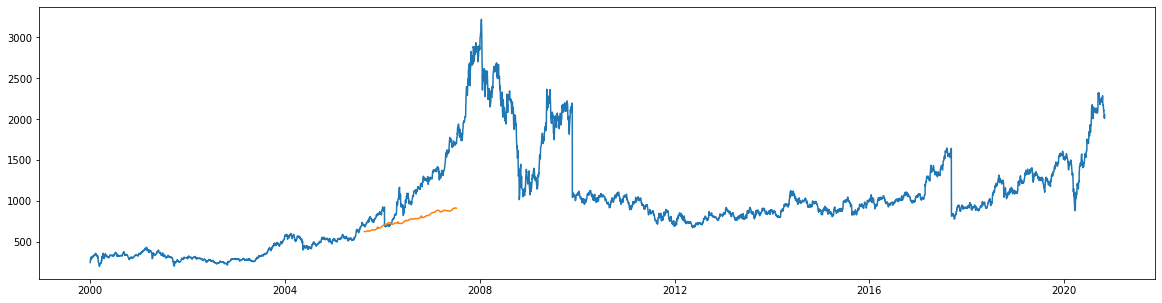

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

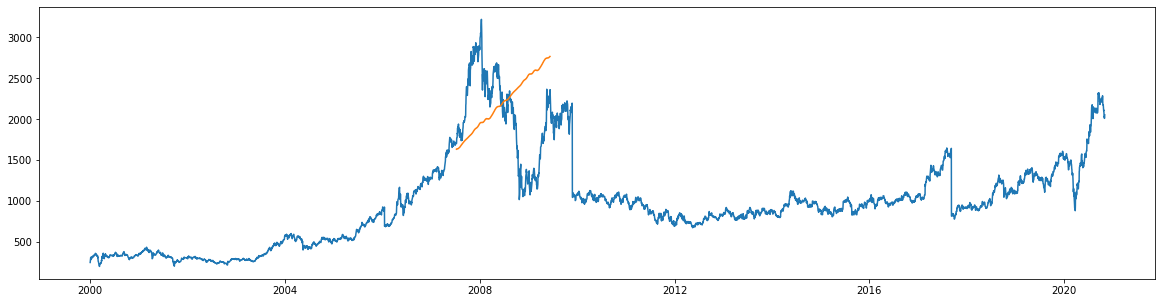

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

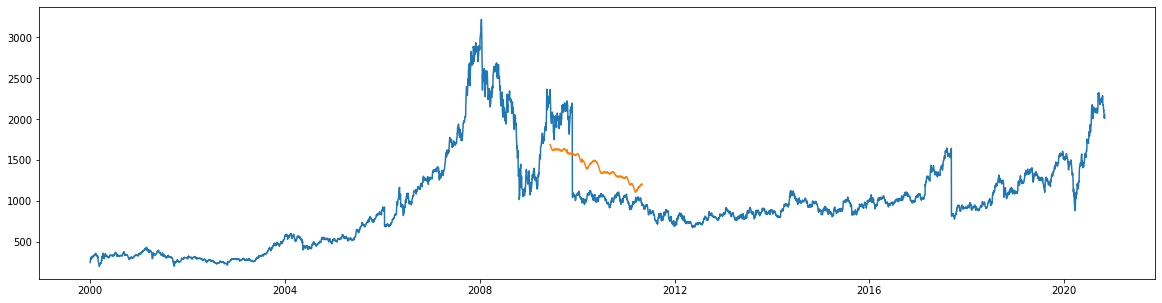

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

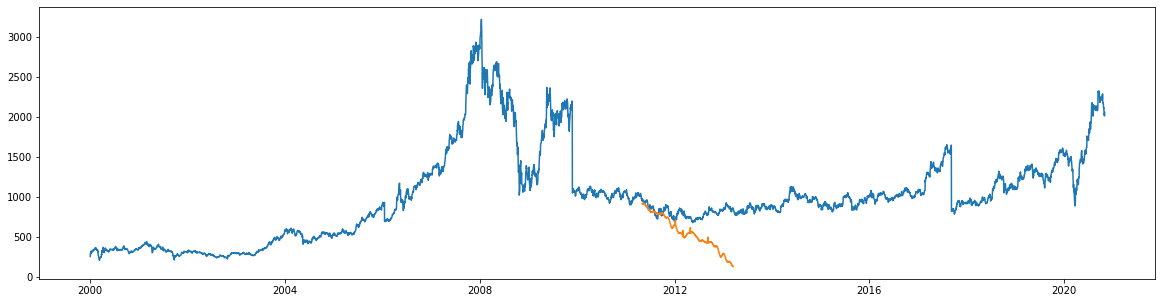

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

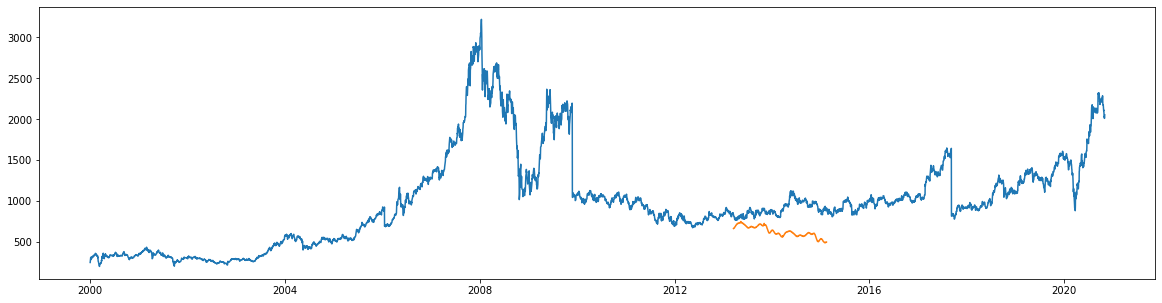

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

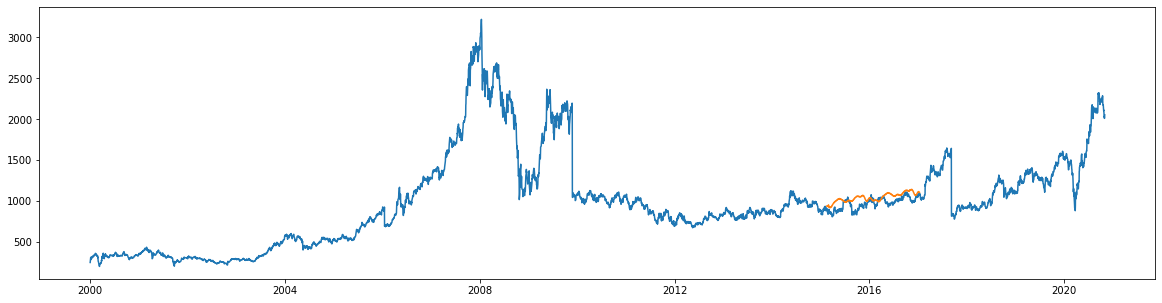

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

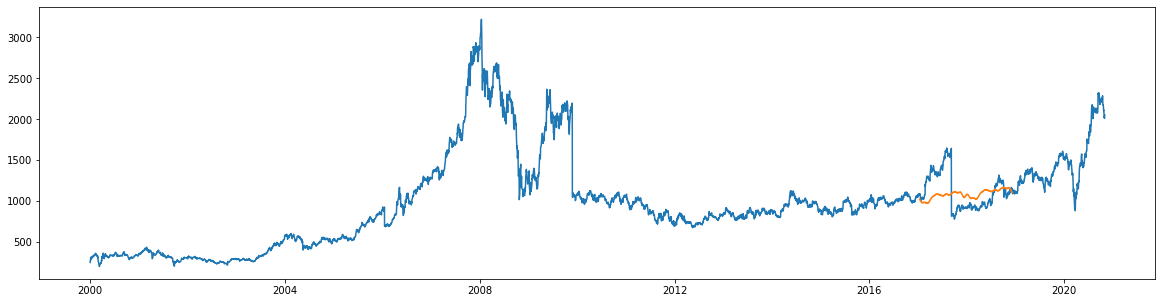

RMSE value = 3.2031369021504785


<Figure size 1440x360 with 0 Axes>

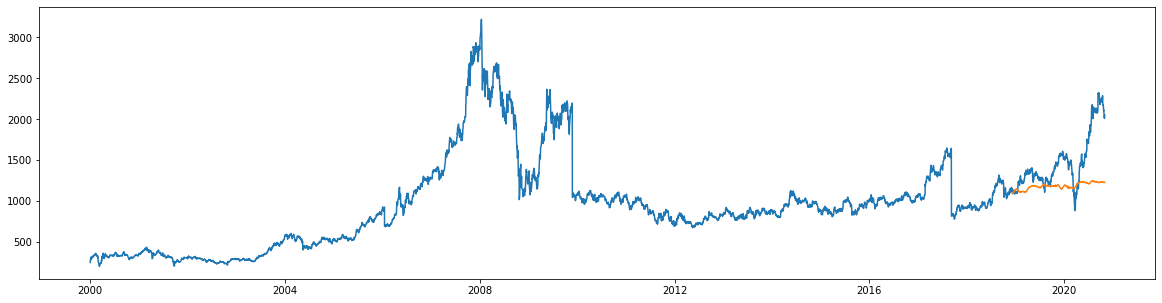

RMSE value = 3.2031369021504785


In [128]:
rmses_pr = []
for train_index,test_index in fn_ts.split(X):
    x_train = pd.DataFrame(y.values[train_index], columns=["Close"])
    x_train["Date"] = y.index[train_index]
    x_test = pd.DataFrame(y.values[test_index], columns=["Close"])
    x_test["Date"] = y.index[test_index]
    model = Prophet(daily_seasonality=True)
    model.fit(x_train[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"}))
    forecast = model.predict(x_test[["Date", "Close"]].rename(columns={"Date": "ds"}))
    y_pred = forecast.yhat
    plt.figure(figsize=(20, 5))
    plot(y.index[test_index], y_pred)
    # rmse = get_rmse(y_test["Close"], y_pred)
    rmses_pr.append(rmse)
    print("RMSE value =", rmse)

In [129]:
rmse_pr_avg = np.mean(rmses_pr)
print("RMSE value for Prophet (average across time series splits) =", rmse_pr_avg)

RMSE value for Prophet (average across time series splits) = 3.2031369021504785


# ARIMA

In [130]:
X_train_ar = y[:cut]
X_test_ar = y[cut:]

## Without folding

In [131]:
arima_model = pmd.auto_arima(X_train_ar)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4147
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -20291.175
Date:                Sat, 05 Dec 2020   AIC                          40592.350
Time:                        05:02:11   BIC                          40624.000
Sample:                             0   HQIC                         40603.549
                               - 4147                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2511      0.027     46.674      0.000       1.199       1.304
ar.L2         -0.8542      0.028    -30.566      0.000      -0.909      -0.799
ma.L1         -1.2119      0.031    -39.250      0.000      -1.272      -1.151
ma.L2          0.7957      0.032     24.697      0.000       0.733       0.859
sigma2      1044.2722      2.052    508.894      0.000    1040.250    1048.294
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):          23549007.07
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                           -10.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       371.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
y_pred_ar = arima_model.predict(X_test_ar.shape[0])

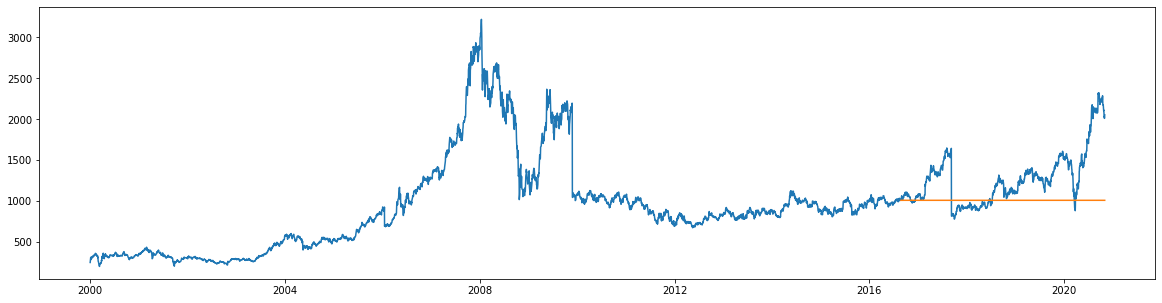

RMSE value -  423.5868282113122


In [133]:
plt.figure(figsize=(20, 5))
plt.plot(y)
plt.plot(X_test_ar.index, y_pred_ar)
plt.show()
rmse_arima_fl = get_rmse(X_test_ar, y_pred_ar)
print("RMSE value - ", rmse_arima_fl)

## With folding

<Figure size 1440x360 with 0 Axes>

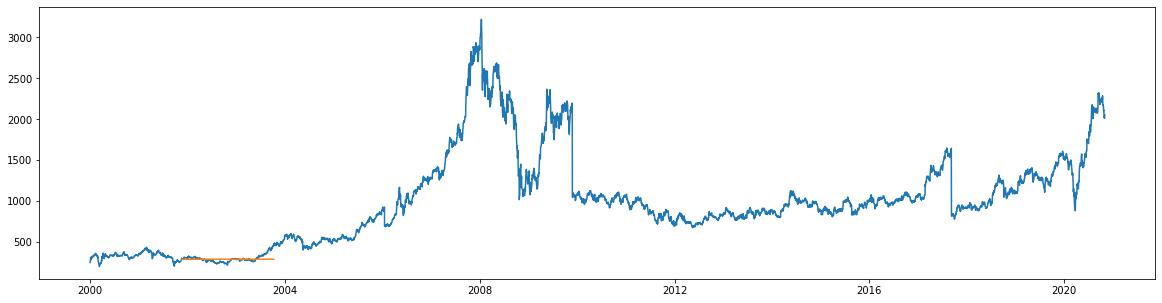

RMSE value = 45.0805414798998


<Figure size 1440x360 with 0 Axes>

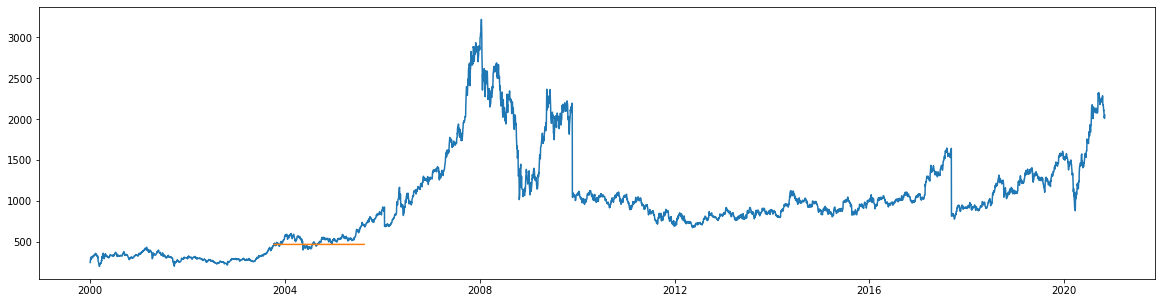

RMSE value = 86.48783442315619


<Figure size 1440x360 with 0 Axes>

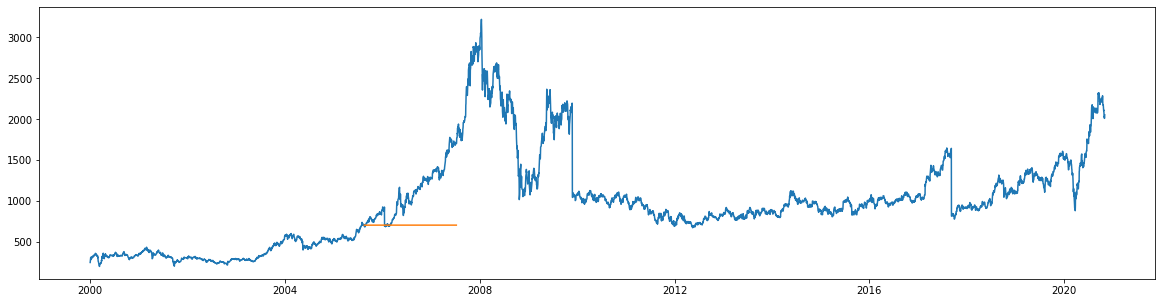

RMSE value = 496.63891799838314


<Figure size 1440x360 with 0 Axes>

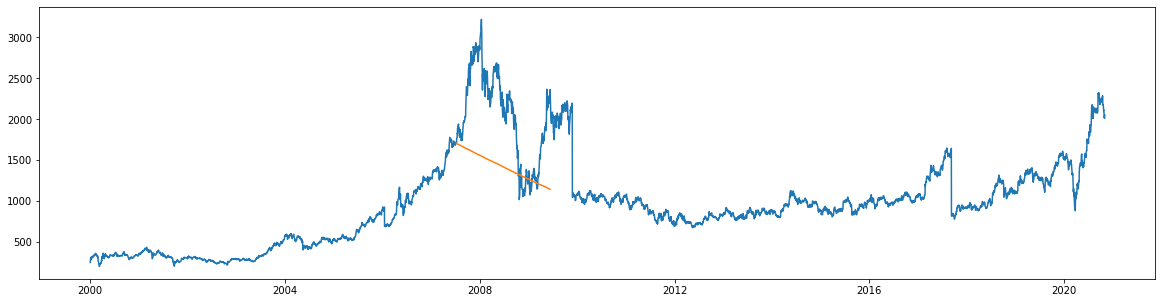

RMSE value = 784.0507244299778


<Figure size 1440x360 with 0 Axes>

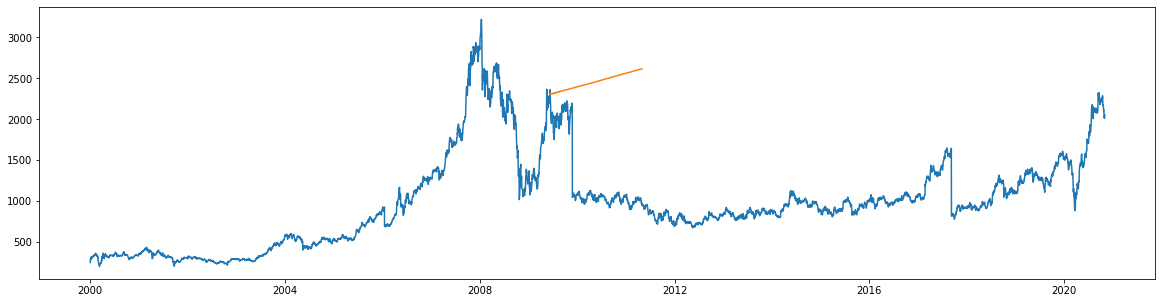

RMSE value = 1291.775084605719


<Figure size 1440x360 with 0 Axes>

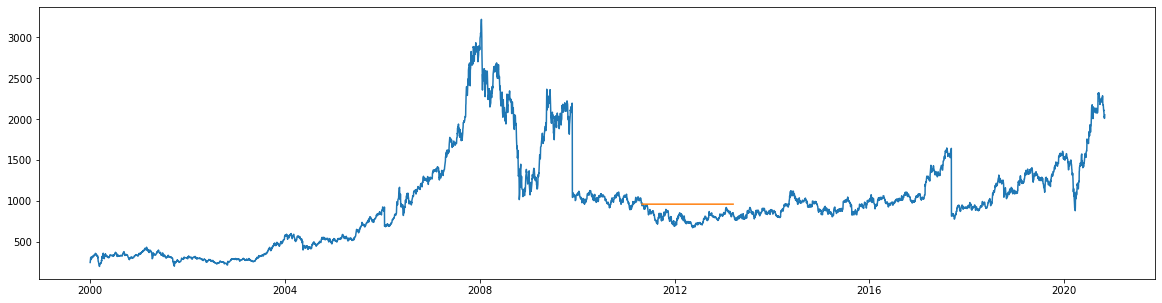

RMSE value = 170.9077759063656


<Figure size 1440x360 with 0 Axes>

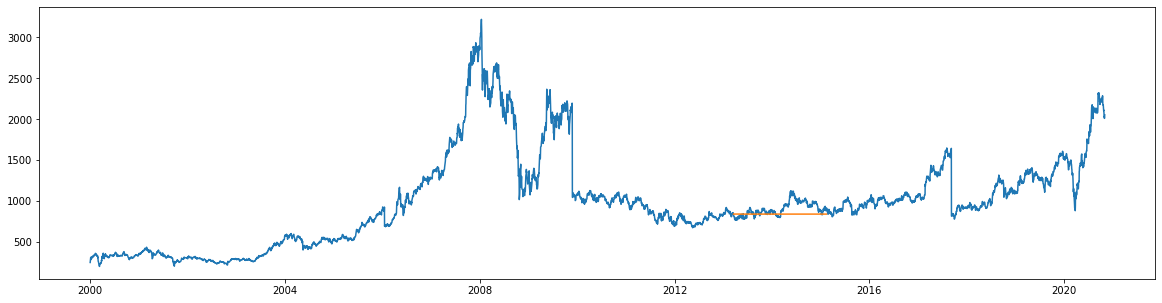

RMSE value = 102.92426434909355


<Figure size 1440x360 with 0 Axes>

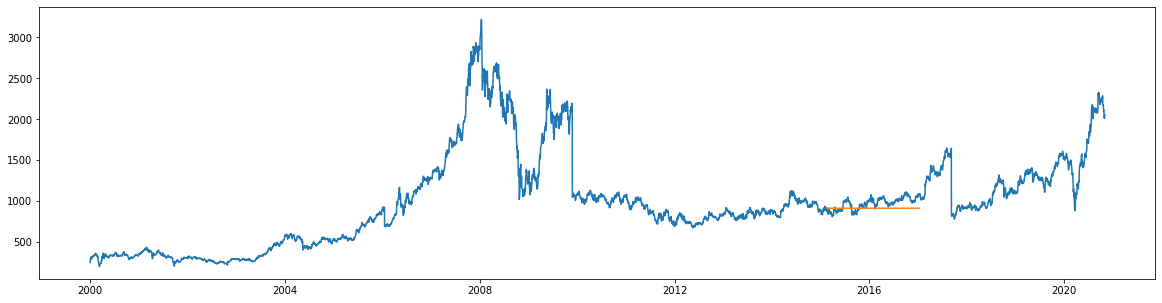

RMSE value = 89.9699112228998


<Figure size 1440x360 with 0 Axes>

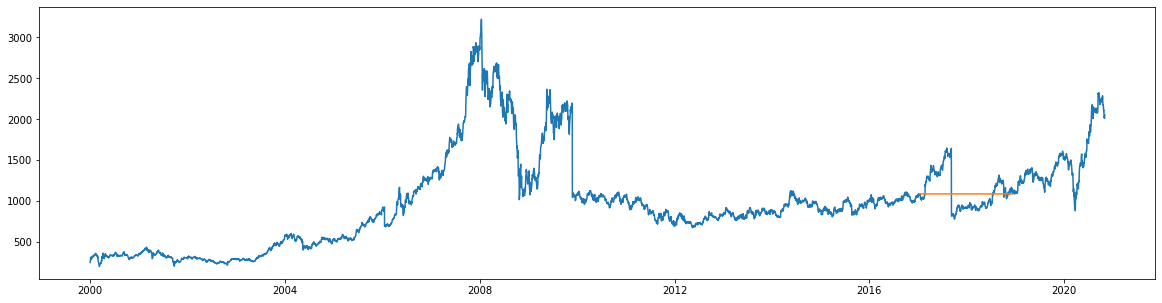

RMSE value = 222.92294436730182


<Figure size 1440x360 with 0 Axes>

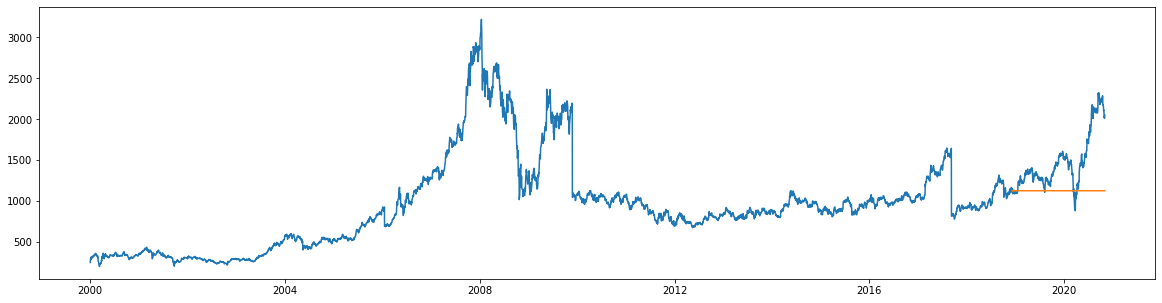

RMSE value = 487.3130804385699


In [143]:
rmses_arima = []
for train_index,test_index in fn_ts.split(X):
    x_train = pd.DataFrame(y.values[train_index], columns=["Close"], index=y.index[train_index])
    x_test = pd.DataFrame(y.values[test_index], columns=["Close"], index=y.index[test_index])
    arima_model = pmd.auto_arima(x_train)
    y_pred = arima_model.predict(x_test.shape[0])
    plt.figure(figsize=(20, 5))
    plot(y.index[test_index], y_pred)
    rmse = get_rmse(x_test["Close"], y_pred)
    rmses_arima.append(rmse)
    print("RMSE value =", rmse)

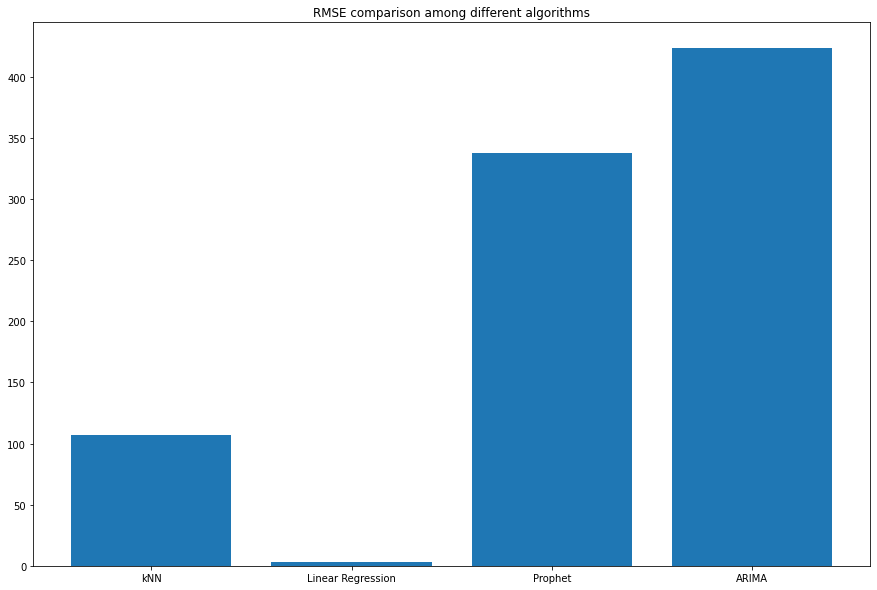

In [144]:
plt.figure(figsize=(15, 10))
plt.bar(["kNN", "Linear Regression", "Prophet", "ARIMA"], [rmse_knn_fl, rmse_lr_fl, rmse_pr_fl, rmse_arima_fl])
plt.title("RMSE comparison among different algorithms")
plt.show()